In [26]:
from main import RF
from mmdit import MMDiT_for_IN1K
import torch



rf = RF(
    MMDiT_for_IN1K(
        in_channels=4,
        out_channels=4,
        dim=1536,
        global_conddim=1536,
        n_layers=6,
        n_heads=8,
    ),
    True,
).cuda()

rf.load_state_dict(torch.load('/home/host/simo/ckpts/largerun/model_151201/ema2.pt')) # checkpoint after getting high loss
rf.eval()

    

RF(
  (model): MMDiT_for_IN1K(
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1536, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1536, out_features=1536, bias=True)
      )
    )
    (c_vec_embedder): Embedding(1024, 1536)
    (cond_seq_linear): MultiTokenEmbedding(
      (embedding1): Embedding(1024, 1536)
      (embedding2): Embedding(1024, 1536)
    )
    (init_x_linear): Linear(in_features=16, out_features=1536, bias=True)
    (layers): ModuleList(
      (0-4): 5 x MMDiTBlock(
        (normC1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (normC2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlpC): MLP(
          (c_fc1): Linear(in_features=1536, out_features=4096, bias=False)
          (c_fc2): Linear(in_features=1536, out_features=4096, bias=False)
          (c_proj): Linear(in_features=4096, out_features=1536, bias=False)
        )
        (modC): Sequential(
 

In [42]:
init_noise = torch.randn(16, 4, 32, 32).cuda()
conds = [933, 849, 94, 230] * 4
conds = [1, 94, 333, 980] * 4
conds = torch.tensor(conds).cuda()
images = rf.sample(init_noise, conds, null_cond = torch.tensor([1000] * 16).cuda(), sample_steps = 50, cfg = 4.0)

In [13]:
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [43]:
images_for_grid = [[] for _ in range(4)]

for i, labidx in enumerate(conds[:4]):
    for t in range(50):
        x = vae.decode(images[t][i : i + 1].cuda()/0.13025).sample
        img = VaeImageProcessor().postprocess(
            image=x.detach(), do_denormalize=[True, True]
        )[0]
        images_for_grid[i].append(img)

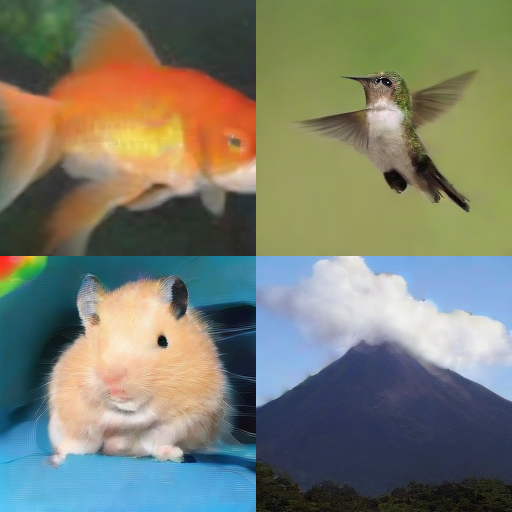

In [44]:
# plot 4 of them in grid
import PIL.Image as Image
grid_images = []

for t in range(50):
    
    grid = Image.new('RGB', (256*2, 256*2))
    for i in range(4):
        grid.paste(images_for_grid[i][t], (256*(i%2), 256*(i//2)))
    grid_images.append(grid)

# make it gif
# make last image lnger
grid_images += [grid_images[-1]] * 15
grid_images[-1]

In [ ]:
grid_images[0].save('out.gif', save_all=True, append_images=grid_images[1:], duration=100, loop=0)
